## TOC:
* [First Bullet Header](#first-bullet)

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler, LabelEncoder

from sklearn.impute import SimpleImputer

from sklearn_pandas import DataFrameMapper

from sklearn.metrics import accuracy_score,r2_score, roc_auc_score

In [111]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model



In [3]:
data=pd.read_csv('data/final.csv' ,encoding = "ISO-8859-1")

In [4]:
data.head()

,uuid,Unnamed: 0,ATP,B365L,B365W,Best of,Comment,Court,Date,L1,...,one_three_vv,one_five_vv,pts_diff,player_one_pts,player_two_pts,player_one_total_games,player_two_total_games,total_sets,player_one_sets,player_two_sets
0,73f14b1f-a9af-4ef9-88a0-df3b4ff82e12,0,1,1.72,2.00,3,Completed,Outdoor,1/6/20,3.0,...,1.0,0.0,-192,1111,919,12,7,2.0,0.0,2.0
1,77cb58d6-44ed-4875-a622-4c6839b08072,1,1,2.25,1.57,3,Completed,Outdoor,1/6/20,6.0,...,1.0,0.0,-165,803,638,13,10,2.0,0.0,2.0
2,9bee2c88-a8e5-4169-b0d6-5ad4a030d689,2,1,3.75,1.25,3,Completed,Outdoor,1/6/20,4.0,...,1.0,0.0,158,1025,867,12,7,2.0,2.0,0.0
3,e7a40475-873d-426e-b37d-7f4c0dbd11c3,3,1,1.83,1.83,3,Completed,Outdoor,1/6/20,6.0,...,1.0,0.0,224,905,681,15,13,3.0,2.0,1.0
4,2b89806d-1688-4364-88c6-c1ffc499e63e,4,1,2.50,1.50,3,Completed,Outdoor,1/6/20,3.0,...,1.0,0.0,284,920,636,15,12,3.0,2.0,1.0


In [21]:
data.groupby('Comment')['Comment'].count()/len(data)

Comment
Awarded         0.000035
Completed       0.961710
Disqualified    0.000035
Retired         0.031937
Sched           0.000069
Walkover        0.006215
Name: Comment, dtype: float64

In [22]:
data=data[data.Comment=='Completed']

In [31]:
data.columns

Index(['uuid', 'Unnamed: 0', 'ATP', 'B365L', 'B365W', 'Best of', 'Comment',
       'Court', 'Date', 'L1', 'L2', 'L3', 'L4', 'L5', 'LPts', 'LRank',
       'Location', 'Loser', 'Lsets', 'Round', 'Series', 'Surface',
       'Tournament', 'W1', 'W2', 'W3', 'W4', 'W5', 'WPts', 'WRank', 'Winner',
       'Wsets', 'rank_diff', 'outcome', 'player_one', 'player_two',
       'player_one_rank', 'player_two_rank', 'uuid.1', 'one_name', 'one_date',
       'one_cutoff_date', 'one_win_rate_year', 'one_games_played_year',
       'one_clay_year', 'one_grass_year', 'one_hard_year', 'one_three_year',
       'one_five_year', 'two_name', 'two_date', 'two_cutoff_date',
       'two_win_rate_year', 'two_games_played_year', 'two_clay_year',
       'two_grass_year', 'two_hard_year', 'two_three_year', 'two_five_year',
       'major', 'total_games', 'player_two_name_vv', 'two_cutoff_date_vv',
       'two_win_rate_vv', 'two_games_played_vv', 'two_clay_vv', 'two_grass_vv',
       'two_hard_vv', 'two_three_vv', 'two_

In [23]:
print("% of games with only top 100 players: ",len(data[(data.WRank<=100) & (data.LRank<=100)])/len(data))

% of games with only top 100 players:  0.6574639190062469


In [24]:
# % of times the higher ranked player one
data.groupby('outcome')['outcome'].count()/len(data)

outcome
0    0.335715
1    0.664285
Name: outcome, dtype: float64

In [25]:
# % of times the higher ranked player one in 5set games
data[data['Best of']==5].groupby('outcome')['outcome'].count()/len(data[data['Best of']==5])

outcome
0    0.259141
1    0.740859
Name: outcome, dtype: float64

In [26]:
# % of times the higher ranked player one in 5set games
data[data['Best of']==3].groupby('total_sets')['total_sets'].count()

total_sets
0.0        2
1.0        4
2.0    14463
3.0     8076
4.0        1
5.0        2
Name: total_sets, dtype: int64

In [27]:
data[(data['Best of']==3) & (data.total_sets==1.0)]

,uuid,Unnamed: 0,ATP,B365L,B365W,Best of,Comment,Court,Date,L1,...,one_three_vv,one_five_vv,pts_diff,player_one_pts,player_two_pts,player_one_total_games,player_two_total_games,total_sets,player_one_sets,player_two_sets
2269,cb581777-523b-432b-b342-57306d65cbbf,2206,53,3.00,1.4,3,Completed,Indoor,9/22/19,7.0,...,1.0,0.000000,190,955,765,9,11,1.0,0.0,1.0
7533,a14edf1d-42c3-4bc6-92e8-f3b51bc7440d,2229,54,1.53,2.5,3,Completed,Indoor,9/24/17,5.0,...,0.5,0.000000,-541,1085,544,13,7,1.0,0.0,1.0
10460,562bb080-8010-44e0-9fc4-2c63febfb817,2532,63,1.61,2.3,3,Completed,Indoor,10/30/16,1.0,...,0.8,0.666667,-1960,4650,2690,13,7,1.0,0.0,1.0
13078,61de4009-c143-4df0-b53b-d6065966da91,2532,63,1.61,2.3,3,Completed,Indoor,10/30/16,1.0,...,0.8,0.666667,-1960,4650,2690,13,7,1.0,0.0,1.0


In [30]:
data['rank_dif']=data['player_two_rank']-data['player_one_rank']
data['pts_dif']=data['player_two_pts']-data['player_one_pts']
data['win_rate_diff']=data['two_win_rate_year']-data['one_win_rate_year']
data['hard_diff']=data['two_hard_year']-data['one_hard_year']
data['five_diff']=data['two_five_year']-data['one_five_year']
data['three_diff']=data['two_three_year']-data['one_three_year']

data['hard_vv']=data['two_hard_vv']-data['one_hard_vv']
data['vv']=data['two_win_rate_vv']-data['one_win_rate_vv']




/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

## Model to predict match <a class="anchor" id="first-bullet"></a>

In [32]:
data.head()

,uuid,Unnamed: 0,ATP,B365L,B365W,Best of,Comment,Court,Date,L1,...,player_one_sets,player_two_sets,rank_dif,pts_dif,win_rate_diff,hard_diff,five_diff,three_diff,hard_vv,vv
0,73f14b1f-a9af-4ef9-88a0-df3b4ff82e12,0,1,1.72,2.00,3,Completed,Outdoor,1/6/20,3.0,...,0.0,2.0,12,-192,0.124772,0.102871,0.033333,0.117500,-1.0,-1.0
1,77cb58d6-44ed-4875-a622-4c6839b08072,1,1,2.25,1.57,3,Completed,Outdoor,1/6/20,6.0,...,0.0,2.0,13,-165,-0.033871,-0.021645,0.111111,-0.097403,-1.0,-1.0
2,9bee2c88-a8e5-4169-b0d6-5ad4a030d689,2,1,3.75,1.25,3,Completed,Outdoor,1/6/20,4.0,...,2.0,0.0,15,-158,0.032741,-0.115468,-0.012987,0.044974,-1.0,-1.0
3,e7a40475-873d-426e-b37d-7f4c0dbd11c3,3,1,1.83,1.83,3,Completed,Outdoor,1/6/20,6.0,...,2.0,1.0,18,-224,0.110256,0.000000,0.166667,0.079545,-1.0,-1.0
4,2b89806d-1688-4364-88c6-c1ffc499e63e,4,1,2.50,1.50,3,Completed,Outdoor,1/6/20,3.0,...,2.0,1.0,29,-284,0.072727,0.003030,-0.214286,0.166667,-1.0,-1.0


In [87]:
data.shape

(25290, 42)

In [53]:
t=data


In [88]:

feature_columns=['player_one_rank','player_two_rank','Surface', 'Best of','one_win_rate_year',
       'one_games_played_year', 'one_clay_year', 'one_grass_year',
       'one_hard_year', 'one_three_year', 'one_five_year', 'two_win_rate_year',
       'two_games_played_year', 'two_clay_year', 'two_grass_year',
       'two_hard_year', 'two_three_year', 'two_five_year', 'major','one_win_rate_vv', 'one_games_played_vv', 'one_clay_vv', 'one_grass_vv',
       'one_hard_vv', 'one_three_vv', 'one_five_vv','two_win_rate_vv',
       'two_games_played_vv', 'two_clay_vv', 'two_grass_vv', 'two_hard_vv',
       'two_three_vv', 'two_five_vv', 'rank_dif', 'win_rate_diff', 'hard_diff',
       'five_diff', 'three_diff', 'hard_vv', 'vv' ,'pts_diff', 'outcome']
data=data[feature_columns].dropna()

In [89]:
target='outcome'
y=data[target]
X=data.drop('outcome',axis=1)

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=117)

In [131]:
mapper = DataFrameMapper([
    (['player_one_rank'], [StandardScaler(),SimpleImputer()]),
    (['player_two_rank'], [StandardScaler(),SimpleImputer()]),
    (['Surface'], [SimpleImputer(strategy='constant', fill_value='most_frequent'),LabelBinarizer()]),
    ('Best of', LabelEncoder()),
    (['one_win_rate_year'],StandardScaler()),
    (['one_games_played_year'], StandardScaler()),
    (['one_clay_year'], StandardScaler()),
    (['one_grass_year'],StandardScaler()),
    (['one_hard_year'], StandardScaler()),
    (['one_three_year'], StandardScaler()),
    (['one_five_year'], StandardScaler()),
    (['two_win_rate_year'],StandardScaler()),
    (['two_games_played_year'], StandardScaler()),
    (['two_clay_year'], StandardScaler()),
    (['two_grass_year'],StandardScaler()),
    (['two_hard_year'], StandardScaler()),
    (['two_three_year'], StandardScaler()),
    (['two_five_year'], StandardScaler()),
    ('major', LabelEncoder()),
    (['one_win_rate_vv'],StandardScaler()), 
    (['one_games_played_vv'],StandardScaler()),  
    (['one_clay_vv'],StandardScaler()),  
    (['one_grass_vv'],StandardScaler()), 
    (['one_hard_vv'],StandardScaler()),  
    (['one_three_vv'],StandardScaler()),  
    (['one_five_vv'],StandardScaler()),
    (['two_win_rate_vv'],StandardScaler()), 
    (['two_games_played_vv'],StandardScaler()),  
    (['two_clay_vv'],StandardScaler()),  
    (['two_grass_vv'],StandardScaler()), 
    (['two_hard_vv'],StandardScaler()),  
    (['two_three_vv'],StandardScaler()),  
    (['two_five_vv'],StandardScaler()),    
    (['rank_dif'],StandardScaler()),  
    #(['pts_diff'],[StandardScaler(),SimpleImputer()]),  
    (['win_rate_diff'],StandardScaler()),  
    (['hard_diff'],StandardScaler()),
    (['five_diff'],StandardScaler()), 
    (['three_diff'],StandardScaler()),
    (['hard_vv'],StandardScaler()),
    (['vv'],StandardScaler())
    
], df_out=
    True)


In [132]:
%%time
Z_train=mapper.fit_transform(X_train)
Z_test=mapper.transform(X_test)

CPU times: user 256 ms, sys: 32.7 ms, total: 288 ms
Wall time: 305 ms


In [133]:
model=LogisticRegression(C=20, max_iter=1000, n_jobs=1)

In [134]:
model.fit(Z_train,y_train)

LogisticRegression(C=20, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [135]:
model.score(Z_train,y_train)

0.6916271253459866

In [136]:
y_pred=model.predict(Z_test)

In [137]:
accuracy_score(y_test,y_pred),roc_auc_score(y_test,y_pred)

(0.6795175958877027, 0.5935484408246203)

In [127]:
Z_train.columns[model.coef_.argsort()]

Index([['two_three_year', 'two_games_played_year', 'three_diff', 'major', 'one_three_year', 'Surface_Clay', 'player_one_rank', 'one_games_played_vv', 'two_games_played_vv', 'hard_vv', 'Surface_Hard', 'two_grass_vv', 'two_grass_year', 'one_grass_vv', 'two_clay_year', 'two_hard_year', 'hard_diff', 'one_win_rate_vv', 'five_diff', 'two_five_year', 'Best of', 'one_clay_year', 'one_hard_year', 'two_five_vv', 'one_five_year', 'one_three_vv', 'two_clay_vv', 'vv', 'two_win_rate_vv', 'two_three_vv', 'one_grass_year', 'two_hard_vv', 'one_five_vv', 'player_two_rank', 'rank_dif', 'one_hard_vv', 'Surface_Grass', 'one_clay_vv', 'win_rate_diff', 'one_games_played_year', 'one_win_rate_year', 'two_win_rate_year', 'pts_diff']], dtype='object')

In [138]:
m = Sequential()
m.add(Dense(units=64, activation='relu', input_shape=(Z_train.shape[1],)))
m.add(Dropout(0.2))
m.add(Dense(units=32, activation='relu'))
m.add(Dropout(0.2))
m.add(Dense(units=16, activation='relu'))
m.add(Dropout(0.2))
m.add(Dense(units=5, activation='relu'))
m.add(Dropout(0.2))
m.add(Dense(units=1, activation='sigmoid'))

m.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
mc=ModelCheckpoint('data/best_model.h5', monitor='val_accuracy', mode='max', verbose=2, save_best_only=True)
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=15)

In [139]:
hist = m.fit( Z_train,
                    y_train, 
                    batch_size=128,
                    validation_data=(Z_test, y_test),
                    epochs=175,
                    callbacks=[mc],
                    verbose=1)

Train on 20232 samples, validate on 5058 samples
Epoch 1/175
20096/20232 [============================>.] - ETA: 0s - loss: 0.6127 - accuracy: 0.6554
Epoch 00001: val_accuracy improved from -inf to 0.66074, saving model to data/best_model.h5
20232/20232 [==============================] - 1s 52us/sample - loss: 0.6127 - accuracy: 0.6551 - val_loss: 0.5618 - val_accuracy: 0.6607
Epoch 2/175
17920/20232 [=========================>....] - ETA: 0s - loss: 0.5763 - accuracy: 0.6742
Epoch 00002: val_accuracy improved from 0.66074 to 0.68031, saving model to data/best_model.h5
20232/20232 [==============================] - 0s 20us/sample - loss: 0.5768 - accuracy: 0.6734 - val_loss: 0.5528 - val_accuracy: 0.6803
Epoch 3/175
19712/20232 [============================>.] - ETA: 0s - loss: 0.5661 - accuracy: 0.6841
Epoch 00003: val_accuracy improved from 0.68031 to 0.68901, saving model to data/best_model.h5
20232/20232 [==============================] - 0s 20us/sample - loss: 0.5658 - accuracy: 0

Epoch 27/175
19840/20232 [============================>.] - ETA: 0s - loss: 0.5109 - accuracy: 0.7189
Epoch 00027: val_accuracy did not improve from 0.72143
20232/20232 [==============================] - 0s 15us/sample - loss: 0.5115 - accuracy: 0.7182 - val_loss: 0.5136 - val_accuracy: 0.7167
Epoch 28/175
17408/20232 [========================>.....] - ETA: 0s - loss: 0.5114 - accuracy: 0.7199
Epoch 00028: val_accuracy did not improve from 0.72143
20232/20232 [==============================] - 0s 17us/sample - loss: 0.5114 - accuracy: 0.7189 - val_loss: 0.5141 - val_accuracy: 0.7175
Epoch 29/175
19328/20232 [===========================>..] - ETA: 0s - loss: 0.5109 - accuracy: 0.7167
Epoch 00029: val_accuracy did not improve from 0.72143
20232/20232 [==============================] - 0s 16us/sample - loss: 0.5109 - accuracy: 0.7162 - val_loss: 0.5137 - val_accuracy: 0.7165
Epoch 30/175
18304/20232 [==========================>...] - ETA: 0s - loss: 0.5096 - accuracy: 0.7180
Epoch 00030: 

Epoch 55/175
18944/20232 [===========================>..] - ETA: 0s - loss: 0.4939 - accuracy: 0.7385
Epoch 00055: val_accuracy did not improve from 0.72380
20232/20232 [==============================] - 0s 16us/sample - loss: 0.4940 - accuracy: 0.7386 - val_loss: 0.5110 - val_accuracy: 0.7191
Epoch 56/175
18304/20232 [==========================>...] - ETA: 0s - loss: 0.4920 - accuracy: 0.7443
Epoch 00056: val_accuracy did not improve from 0.72380
20232/20232 [==============================] - 0s 16us/sample - loss: 0.4913 - accuracy: 0.7440 - val_loss: 0.5112 - val_accuracy: 0.7185
Epoch 57/175
18816/20232 [==========================>...] - ETA: 0s - loss: 0.4938 - accuracy: 0.7425
Epoch 00057: val_accuracy did not improve from 0.72380
20232/20232 [==============================] - 0s 16us/sample - loss: 0.4938 - accuracy: 0.7432 - val_loss: 0.5107 - val_accuracy: 0.7216
Epoch 58/175
18176/20232 [=========================>....] - ETA: 0s - loss: 0.4918 - accuracy: 0.7419
Epoch 00058: 

Epoch 83/175
19072/20232 [===========================>..] - ETA: 0s - loss: 0.4849 - accuracy: 0.7519
Epoch 00083: val_accuracy did not improve from 0.72855
20232/20232 [==============================] - 0s 16us/sample - loss: 0.4855 - accuracy: 0.7514 - val_loss: 0.5056 - val_accuracy: 0.7250
Epoch 84/175
20224/20232 [============================>.] - ETA: 0s - loss: 0.4779 - accuracy: 0.7528
Epoch 00084: val_accuracy did not improve from 0.72855
20232/20232 [==============================] - 0s 15us/sample - loss: 0.4779 - accuracy: 0.7528 - val_loss: 0.5104 - val_accuracy: 0.7165
Epoch 85/175
19584/20232 [============================>.] - ETA: 0s - loss: 0.4874 - accuracy: 0.7507
Epoch 00085: val_accuracy did not improve from 0.72855
20232/20232 [==============================] - 0s 15us/sample - loss: 0.4860 - accuracy: 0.7522 - val_loss: 0.5056 - val_accuracy: 0.7177
Epoch 86/175
18176/20232 [=========================>....] - ETA: 0s - loss: 0.4786 - accuracy: 0.7566
Epoch 00086: 

Epoch 111/175
19584/20232 [============================>.] - ETA: 0s - loss: 0.4775 - accuracy: 0.7585
Epoch 00111: val_accuracy did not improve from 0.72855
20232/20232 [==============================] - 1s 27us/sample - loss: 0.4772 - accuracy: 0.7576 - val_loss: 0.5071 - val_accuracy: 0.7224
Epoch 112/175
19840/20232 [============================>.] - ETA: 0s - loss: 0.4793 - accuracy: 0.7583
Epoch 00112: val_accuracy did not improve from 0.72855
20232/20232 [==============================] - 0s 21us/sample - loss: 0.4791 - accuracy: 0.7584 - val_loss: 0.5064 - val_accuracy: 0.7250
Epoch 113/175
18176/20232 [=========================>....] - ETA: 0s - loss: 0.4769 - accuracy: 0.7564
Epoch 00113: val_accuracy did not improve from 0.72855
20232/20232 [==============================] - 1s 29us/sample - loss: 0.4768 - accuracy: 0.7564 - val_loss: 0.5030 - val_accuracy: 0.7258
Epoch 114/175
17664/20232 [=========================>....] - ETA: 0s - loss: 0.4751 - accuracy: 0.7611
Epoch 001

Epoch 139/175
18560/20232 [==========================>...] - ETA: 0s - loss: 0.4715 - accuracy: 0.7645
Epoch 00139: val_accuracy did not improve from 0.72855
20232/20232 [==============================] - 0s 16us/sample - loss: 0.4715 - accuracy: 0.7645 - val_loss: 0.5054 - val_accuracy: 0.7236
Epoch 140/175
19200/20232 [===========================>..] - ETA: 0s - loss: 0.4720 - accuracy: 0.7629
Epoch 00140: val_accuracy did not improve from 0.72855
20232/20232 [==============================] - 0s 16us/sample - loss: 0.4715 - accuracy: 0.7640 - val_loss: 0.5070 - val_accuracy: 0.7222
Epoch 141/175
19328/20232 [===========================>..] - ETA: 0s - loss: 0.4720 - accuracy: 0.7596
Epoch 00141: val_accuracy did not improve from 0.72855
20232/20232 [==============================] - 0s 16us/sample - loss: 0.4722 - accuracy: 0.7589 - val_loss: 0.5062 - val_accuracy: 0.7210
Epoch 142/175
20096/20232 [============================>.] - ETA: 0s - loss: 0.4689 - accuracy: 0.7659
Epoch 001

Epoch 167/175
18304/20232 [==========================>...] - ETA: 0s - loss: 0.4642 - accuracy: 0.7666
Epoch 00167: val_accuracy did not improve from 0.72993
20232/20232 [==============================] - 0s 16us/sample - loss: 0.4636 - accuracy: 0.7663 - val_loss: 0.5063 - val_accuracy: 0.7266
Epoch 168/175
17024/20232 [========================>.....] - ETA: 0s - loss: 0.4680 - accuracy: 0.7659
Epoch 00168: val_accuracy did not improve from 0.72993
20232/20232 [==============================] - 0s 17us/sample - loss: 0.4692 - accuracy: 0.7642 - val_loss: 0.5052 - val_accuracy: 0.7268
Epoch 169/175
18944/20232 [===========================>..] - ETA: 0s - loss: 0.4664 - accuracy: 0.7658
Epoch 00169: val_accuracy did not improve from 0.72993
20232/20232 [==============================] - 0s 19us/sample - loss: 0.4661 - accuracy: 0.7648 - val_loss: 0.5062 - val_accuracy: 0.7242
Epoch 170/175
19328/20232 [===========================>..] - ETA: 0s - loss: 0.4657 - accuracy: 0.7647
Epoch 001

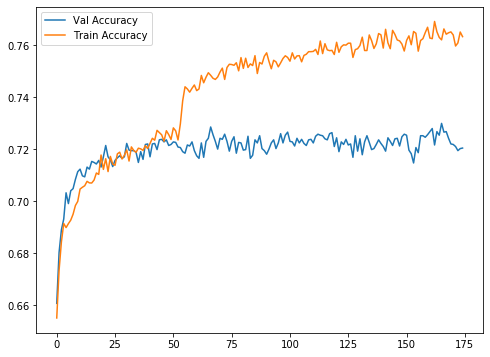

In [140]:
plt.figure(figsize=(8,6))
plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.legend();